## Human In The loop / Human Feedback

In [1]:
import os
from langchain.chat_models import init_chat_model

llm = init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10b352300>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10b54d820>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [2]:
from typing import Annotated
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from the human."""
    human_response = interrupt({"Query": query})
    return human_response["data"]


tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)


def chatBot(state: State):
    messages = llm_with_tools.invoke(state["messages"])

    return {"messages": messages}


graph_builder.add_node("chatBot", chatBot)

tools_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tools_node)


graph_builder.add_edge(START, "chatBot")
graph_builder.add_conditional_edges("chatBot", tools_condition)
graph_builder.add_edge("tools", "chatBot")

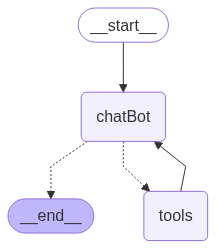

In [3]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
graph

In [4]:
user_input = "Hi, I need some expert assistance for building the AI agent, Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

event  = graph.stream(
    {"messages": [user_input]},
    config=config,
    stream_mode="values")

for event_chunk in event:
    if "messages" in event_chunk:
        event_chunk['messages'][-1].pretty_print()



================================ Human Message =================================

Hi, I need some expert assistance for building the AI agent, Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (k908798kp)
 Call ID: k908798kp
  Args:
    query: I need some expert assistance for building the AI agent, Could you request assistance for me?


In [5]:
human_response = (
    "We, the experts, are here to assist you with building your AI agent. we recommend you to check out the langchain library, which is a powerful tool for building AI agents. It provides a wide range of features and functionalities that can help you in your project. You can find more information about it at https://langchain.com/. If you have any specific questions or need further assistance, feel free to ask!",
    "it is more reliable and extensible than simple autonomous agents. It allows you to build complex AI systems that can handle a wide range of tasks and interactions. If you have any specific questions or need further assistance, feel free to ask!",
)

human_command = Command(resume={'data': human_response})
event = graph.stream(human_command, config=config, stream_mode='values')
for event_chunk in event:
    if "messages" in event_chunk:
        event_chunk['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (k908798kp)
 Call ID: k908798kp
  Args:
    query: I need some expert assistance for building the AI agent, Could you request assistance for me?
================================= Tool Message =================================
Name: human_assistance

["We, the experts, are here to assist you with building your AI agent. we recommend you to check out the langchain library, which is a powerful tool for building AI agents. It provides a wide range of features and functionalities that can help you in your project. You can find more information about it at https://langchain.com/. If you have any specific questions or need further assistance, feel free to ask!", "it is more reliable and extensible than simple autonomous agents. It allows you to build complex AI systems that can handle a wide range of tasks and interactions. If you have any specific questions or need further assistan